In [1]:
import seaborn as sns
import os
import sys
import numpy as np
import random

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from experiments.result_buckets import human_results
from experiments.bucket_analysis import BucketDatasetResult

%load_ext autoreload
%autoreload 2

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 33411.16it/s]


### Main Consistency Section (Section 5)

In [5]:
## section 5 table 3

for dataset in ['snli', 'atomic', 'social', 'anli']:
    bucket_preds = human_results['roberta'][f'{dataset}-human']
    test_preds = human_results['roberta'][f'{dataset}-test']

    print(green(dataset))

    print('P(FLIP):', bucket_preds.calculate_p_flip(test_preds)['flip_prob'])
    print('P(FLIP)-corrected:', bucket_preds.calculate_p_flip(test_preds)['flip_prob_corrected'])
    print('P(FLIP) sanity check:', 2 * bucket_preds.law_of_total_variance_breakdown()['unexplained_variance'])
    print()
    print('P(STAY):', bucket_preds.calculate_p_stay(test_preds)['stay_prob'])
    print('P(STAY)-corrected:', bucket_preds.calculate_p_stay(test_preds)['stay_prob_corrected'])
    print('P(STAY) sanity check:', 1 - bucket_preds.calculate_p_flip(test_preds)['flip_prob'], 'P(STAY)-corrected sanity check:', 1-bucket_preds.calculate_p_flip(test_preds)['flip_prob_corrected'])
    print()
    print('C:', bucket_preds.mean_unweighted_consistency)
    print('C-corrected:', bucket_preds.calculate_weighted_consistency(test_preds))
    print()
    print('POVE:', bucket_preds.law_of_total_variance_breakdown()['POVE'])
    print('POVE-corrected:', bucket_preds.calculate_weighted_proportion_explained(test_preds))
    print("------------------------------------")

snli
P(FLIP): 0.2516600377928949
P(FLIP)-corrected: 0.09904373656625404
P(FLIP) sanity check: 0.2516600377928949

P(STAY): 0.748339962207105
P(STAY)-corrected: 0.9009562634337458
P(STAY) sanity check: 0.7483399622071051 P(STAY)-corrected sanity check: 0.900956263433746

C: 0.7052253968253969
C-corrected: 0.9064806546026608

POVE: 0.4938082810751717
POVE-corrected: 0.6199566340491646
------------------------------------
atomic
P(FLIP): 0.23805147392290255
P(FLIP)-corrected: 0.1290304050075663
P(FLIP) sanity check: 0.23805147392290252

P(STAY): 0.7619485260770974
P(STAY)-corrected: 0.8709695949924339
P(STAY) sanity check: 0.7619485260770975 P(STAY)-corrected sanity check: 0.8709695949924336

C: 0.7478507936507937
C-corrected: 0.8616549681381606

POVE: 0.5186940972384994
POVE-corrected: 0.6258347514649957
------------------------------------
social
P(FLIP): 0.25739435878054917
P(FLIP)-corrected: 0.08064409794189953
P(FLIP) sanity check: 0.2573943587805493

P(STAY): 0.7426056412194502
P(ST

bow
{'consistency': 0.7896619047619047, 'consistency_corrected': 0.775510453009061, 'pove': 0.6420444614924627, 'pove_corrected': 0.6250600845045914, 'flip_prob_corrected': 0.18698226644044685, 'flip_prob': 0.17812780171327786, 'stay_prob_corrected': 0.809207172862765, 'stay_prob': 0.8218721982867218}

test set acc: 0.5574305933587371
paraphrase acc: 0.5368686868686868
paraphrase acc corrected: 0.5255021426626035
bilstm
{'consistency': 0.7037396825396826, 'consistency_corrected': 0.7300803424735418, 'pove': 0.4561960103182316, 'pove_corrected': 0.45970588325296047, 'flip_prob_corrected': 0.2584878775374165, 'flip_prob': 0.26763381204333586, 'stay_prob_corrected': 0.7415121224625836, 'stay_prob': 0.732366187956664}

test set acc: 0.6804572672836146
paraphrase acc: 0.5762626262626263
paraphrase acc corrected: 0.6038732935236668
roberta
{'consistency': 0.7052253968253969, 'consistency_corrected': 0.9064806546026608, 'pove': 0.4938082810751717, 'pove_corrected': 0.6199566340491646, 'flip_p

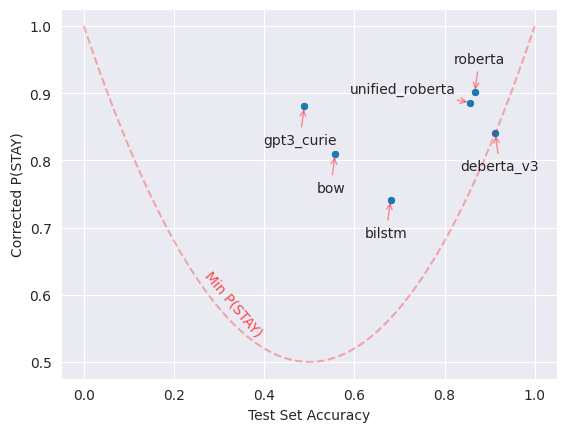

In [58]:
from simple_colors import *
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Import adjust_text function

x = []
y = []
names = []

for model, results in human_results.items():
    analysis = results['snli-human']
    test_results = results['snli-test']

    linguistic_robustness = analysis.linguistic_robustness_summary(test_results)
    
    print(green(model))
    print(linguistic_robustness)
    print('\ntest set acc:', test_results.accuracy)
    print('paraphrase acc:', analysis.paraphrase_accuracy())
    print('paraphrase acc corrected:', analysis.calculate_weighted_paraphrase_accuracy(test_results))
    
    x.append(test_results.accuracy) #analysis.calculate_weighted_paraphrase_accuracy(test_results)) # 
    y.append(linguistic_robustness['stay_prob_corrected'])
    names.append(model)

sns.scatterplot(x=x, y=y)

ax = plt.gca()
ax.set_xlabel("Test Set Accuracy")
ax.set_ylabel("Corrected P(STAY)")

for i in range(len(names)):
    arrow_properties = dict(arrowstyle='->', connectionstyle='arc3', color='red', alpha=0.4)
    if names[i] in ['gpt3_curie', 'bow', 'bilstm']:
        positioning = (x[i] - 0.01, y[i] - 0.05)
    elif names[i] == 'unified_roberta':
        positioning = (x[i] - 0.15, y[i] + 0.02)
    elif names[i] == 'deberta_v3':
        positioning = (x[i] + 0.01, y[i] - 0.05)
    else:
        positioning = (x[i] + 0.01, y[i] + 0.05)

    plt.annotate(names[i], xy=(x[i], y[i]), xytext=positioning, arrowprops=arrow_properties, fontsize=10, ha='center', va='center',)



# plot the bowl
bernoullis = np.linspace(0, 1, 1000)
bernoulli_vars = bernoullis * (1-bernoullis)
min_pstay = 1- 2*bernoulli_vars

ax.plot(bernoullis, max_pstay, 'r--', label='Min P(STAY)', alpha=0.3)
ax.annotate("Min P(STAY)", (bernoullis[400], min_pstay[400]+0.12), rotation=-50, ha='right', va='top', alpha=0.7, color='red')

plt.show()

In [ ]:
import plotly.express as px

# This plot shows that the there is positive correlation between how extreme the confidence is and discrete consistency.

model = human_results['roberta']['snli-human']

x = [b.original_example_prediction.confidence_deviation for b in model.buckets]
y = [b.bucket_discrete_agreement for b in model.buckets]

fig = px.scatter(x=x, y=y, labels={'x': 'deviation', 'y': 'discrete_agreement'}, trendline="ols")

fig.show()

### Unused Figure on Mean Correctness Distribution

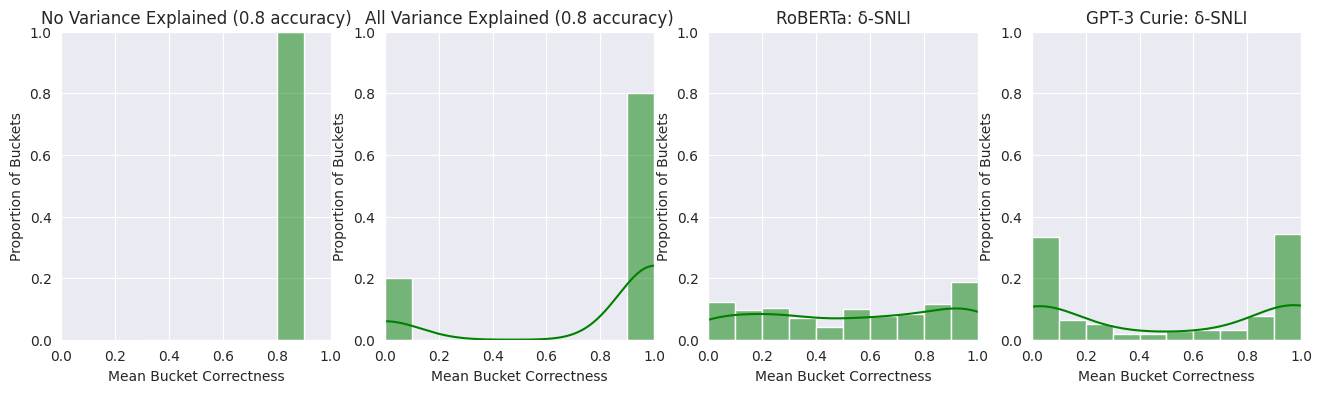

In [3]:
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

plot_data = {
    'No Variance Explained (0.8 accuracy)': {
        'data': [0.8] * len(human_results['roberta']['snli-human'].buckets),
        'color': "green"
    },
    'All Variance Explained (0.8 accuracy)': {
        'data': [1] * int(0.8 * len(human_results['roberta']['snli-human'].buckets)) + [0] * int(0.2 * len(human_results['roberta']['snli-human'].buckets)),
        'color': "green"
    },
    'RoBERTa: δ-SNLI': {
        'data': [b.bucket_correctness_mean for b in human_results['roberta']['snli-human'].buckets],
        'color': "green"
    },
    'GPT-3 Curie: δ-SNLI': {
        'data': [b.bucket_correctness_mean for b in human_results['gpt3_curie']['snli-human'].buckets],
        'color': "green"
    },
}

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, (title, pdata) in enumerate(plot_data.items()):
    sns.histplot(pdata['data'], kde=True, stat='proportion', bins=10, ax=axes[i], color=pdata['color'])
    axes[i].set_xlabel("Mean Bucket Correctness")
    axes[i].set_ylabel("Proportion of Buckets")
    axes[i].set_title(title)
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)

plt.savefig('pove.pdf')
plt.show()


In [12]:
np.var([1, 1, 1, 1, 0])

0.16

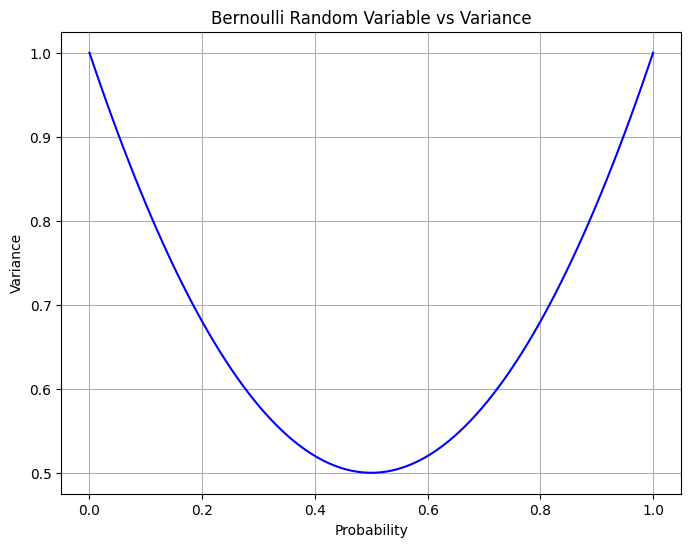

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define a range of probabilities for the Bernoulli distribution
probabilities = 

# Calculate variance for each probability in the range
variances = 

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0, 1, 100), 1 - (2 * (probabilities * (1 - probabilities))), color='blue')
plt.title('Bernoulli Random Variable vs Variance')
plt.xlabel('Probability')
plt.ylabel('Variance')
plt.grid(True)
plt.show()